In [1]:
import os
import numpy as np # linear algebra
import cv2
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tqdm import tqdm
from sklearn.utils import shuffle

In [2]:
#For Keras
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)  # set this TensorFlow session as the default session for Keras

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



In [3]:
image_paths = []
imseg_paths = []

root_directory = os.getcwd()

#ims = 0
#ims_to_read = 10

for x in ['dataA']: # For full dataset ['dataA', 'dataB', 'dataC', 'dataD', 'dataE']
    image_path_dir = root_directory + '/data/' + x + '/' + x + '/' + 'CameraRGB'
    imseg_path_dir = root_directory + '/data/' + x + '/' + x + '/' + 'CameraSeg'
    for dirname, _, filenames in os.walk(image_path_dir):        
        for filename in filenames:
            
            image_path = image_path_dir + '/' + filename
            image_paths.append(image_path)
            imseg_path = imseg_path_dir + '/' + filename
            imseg_paths.append(imseg_path)
            #ims = ims+1
            #if ims == ims_to_read:
                #break
            
# Number of images
num_images = len(image_paths)
print("Total number of images = ", num_images)

Total number of images =  1000


In [4]:
class Args:
    L2_REG = 1e-5
    STDEV = 1e-2
    KEEP_PROB = 0.5
    LEARNING_RATE = 1e-4
    EPOCHS = 10
    BATCH_SIZE = 8
    IMAGE_SHAPE = (224, 224)
    NUM_CLASSES = 1
    SEGMENT = 7 # Segment lable for road

args = Args()

In [5]:
def read_image(path):
    image = cv2.imread(path)
    image = image_resize(image)
    return np.array(image)

def read_imseg(path):
    imseg = np.array(cv2.imread(path))
    imseg = image_resize(imseg)
    imseg = np.array([max(imseg[i, j]) for i in range(imseg.shape[0]) for j in range(imseg.shape[1])]).reshape(imseg.shape[0], imseg.shape[1])   
    return imseg

def image_resize(image):
    height, width = args.IMAGE_SHAPE
    return np.array(cv2.resize(image, (width, height), cv2.INTER_AREA))

def imseg2roadseg(imseg):
    height, width = imseg.shape
    imseg_road = np.zeros((height, width, 1), dtype=np.int8)
    imseg_road[np.where(imseg==args.SEGMENT)[0], np.where(imseg==args.SEGMENT)[1]] = 1
    return np.array(imseg_road)

def pipeline(X_path, y_path):
    image_BGR = read_image(X_path)
    imseg = read_imseg(y_path)
    imseg_road = imseg2roadseg(imseg)
    return image_BGR, imseg_road

In [6]:
# read all the images
def read_data(image_paths,imseg_paths):
    height, width = args.IMAGE_SHAPE
    images = np.zeros((len(image_paths), height, width, 3), dtype=np.int16)
    imsegs_road = np.zeros((len(image_paths), height, width, 1), dtype=np.int8)
    for index in tqdm(range(len(image_paths))):
        X_path, y_path = image_paths[index], imseg_paths[index]
        images[index], imsegs_road[index] = pipeline(X_path, y_path)
    return images, imsegs_road

X, y = read_data(image_paths,imseg_paths)

100%|██████████| 1000/1000 [01:56<00:00,  8.62it/s]


(224, 224, 3)
(224, 224)
(224, 224, 1)


Text(0.5, 1.0, 'Segmented road image')

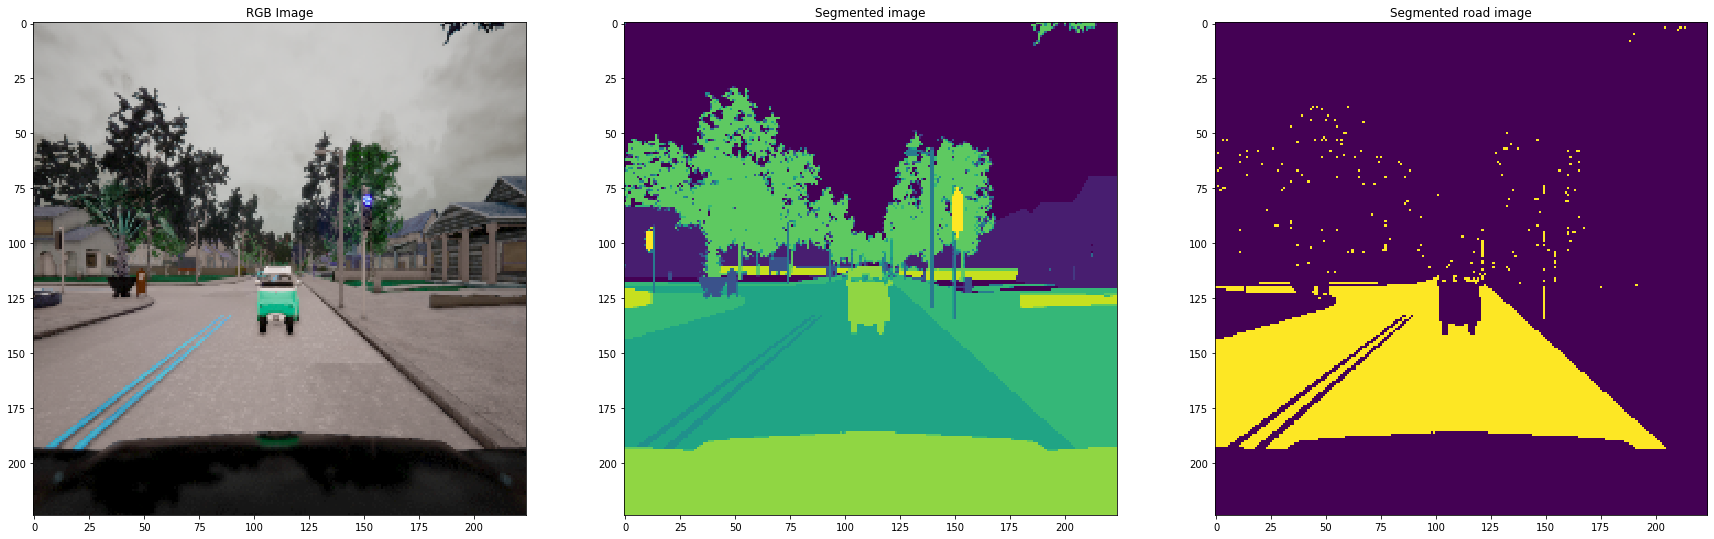

In [7]:
from random import randint
index = randint(0,len(image_paths))
height, width = args.IMAGE_SHAPE
segment = 7

image = read_image(image_paths[index])
imseg = read_imseg(imseg_paths[index])
imseg_road = imseg2roadseg(imseg)

print(image.shape)
print(imseg.shape)
print(imseg_road.shape)

fig, axes = plt.subplots(1, 3, figsize=(30,20))
axes[0].imshow(image)
axes[0].set_title('RGB Image')
axes[1].imshow(imseg)
axes[1].set_title('Segmented image')
axes[2].imshow(imseg_road.reshape(height,width))
axes[2].set_title('Segmented road image')

In [8]:
# Split the data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle =True,  random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, shuffle =True,  random_state=42)

print("Training images = ", len(X_train), "Validation images= ", len(X_val), "Test images = ", len(X_test))


Training images =  765 Validation images=  135 Test images =  100


In [9]:
def seg_model(image_shape, num_classes):

    vgg_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=image_shape, classes=1000)
    #vgg_model.summary()
    
    img_input = vgg_model.layers[0].output

    block3_output = vgg_model.layers[10].output
    block4_output = vgg_model.layers[14].output
    block5_output = vgg_model.layers[18].output
    
    # Freeze the layers except the last 4 layers
    for layer in vgg_model.layers:
        layer.trainable = False
    
    
    # Define the regularizer for the kernel
    kernel_regularizer = tf.keras.regularizers.l2(args.L2_REG)
    
    # Convolutional 1x1 to maintain spacial information of block5_output layer
    block5_conv_1x1 = tf.keras.layers.Conv2D(filters=num_classes, 
                                          kernel_size=1, 
                                          strides=(1, 1), 
                                          padding='same',
                                          kernel_regularizer = kernel_regularizer)(vgg_model.output)

    # Deconv layer
    deconv_block5 = tf.keras.layers.Conv2DTranspose(filters = num_classes,
                                                 kernel_size = 4, 
                                                 strides=(2, 2), 
                                                 padding='same', 
                                                 kernel_regularizer=kernel_regularizer)(block5_conv_1x1)

    
    # Convolutional 1x1 to maintain spacial information of block4_output layer
    block4_conv_1x1 = tf.keras.layers.Conv2D(filters=num_classes, 
                                          kernel_size=1, 
                                          strides=(1, 1), 
                                          padding='same',
                                          kernel_regularizer = kernel_regularizer)(block4_output)

    skip_connection_1 = tf.keras.layers.Add()([deconv_block5, block4_conv_1x1])
    
    # Deconv layer
    deconv_layer_4_5 = tf.keras.layers.Conv2DTranspose(filters = num_classes,
                                                 kernel_size = 4, 
                                                 strides=(2, 2), 
                                                 padding='same', 
                                                 kernel_regularizer=kernel_regularizer)(skip_connection_1)
    
    
    # Convolutional 1x1 to maintain spacial information of vgg_layer 3
    block3_conv_1x1 = tf.keras.layers.Conv2D(filters=num_classes, 
                                          kernel_size=1, 
                                          strides=(1, 1), 
                                          padding='same',
                                          kernel_regularizer = kernel_regularizer)(block3_output)
    
    skip_connection_2 = tf.keras.layers.Add()([deconv_layer_4_5, block3_conv_1x1])
    
    output = tf.keras.layers.Conv2DTranspose(filters = num_classes,
                                                 kernel_size = 16, 
                                                 strides=(8, 8), 
                                                 padding='same', 
                                                 kernel_regularizer=kernel_regularizer)(skip_connection_2)
    
    predictions = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(output)
    model = tf.keras.Model(inputs = vgg_model.input, outputs = predictions, name='seg_model')
    return model



In [12]:
from tensorflow.keras.models import Model
image_shape = (args.IMAGE_SHAPE[0], args.IMAGE_SHAPE[1], 3)
num_classes = args.NUM_CLASSES
my_model = seg_model(image_shape, num_classes)

#compile the model
my_model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

my_model.summary()



Model: "seg_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________

In [16]:
my_model.fit(x=X_train, y=y_train, batch_size=1, epochs=10, verbose=1)

Train on 765 samples
Epoch 1/10
765/765 [==============================] - 21s 27ms/sample - loss: 0.0873 - accuracy: 0.9724
Epoch 2/10
765/765 [==============================] - 21s 27ms/sample - loss: 0.0872 - accuracy: 0.9723
Epoch 3/10
765/765 [==============================] - 21s 27ms/sample - loss: 0.0867 - accuracy: 0.9726
Epoch 4/10
765/765 [==============================] - 21s 28ms/sample - loss: 0.0862 - accuracy: 0.9726
Epoch 5/10
765/765 [==============================] - 21s 28ms/sample - loss: 0.0864 - accuracy: 0.9725
Epoch 6/10
765/765 [==============================] - 21s 27ms/sample - loss: 0.0863 - accuracy: 0.9727
Epoch 7/10
765/765 [==============================] - 21s 28ms/sample - loss: 0.0859 - accuracy: 0.9727
Epoch 8/10
765/765 [==============================] - 21s 27ms/sample - loss: 0.0856 - accuracy: 0.9728
Epoch 9/10
765/765 [==============================] - 21s 27ms/sample - loss: 0.0860 - accuracy: 0.9727
Epoch 10/10
765/765 [======================

In [17]:
my_model.save('final-road-seg-model-v2.h5')

In [18]:
score = my_model.evaluate(X_test, y_test, verbose=2, batch_size=1)

100/1 - 3s - loss: 0.0683 - accuracy: 0.9721


Text(0.5, 1.0, 'Ground truth')

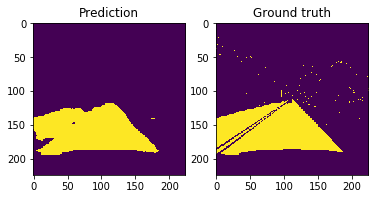

In [19]:
NUMBER = 0
#X_test_cast = tf.cast(X_test, tf.float32)
X_test_cast = X_test.astype(float)
y_pred = my_model.predict(X_test_cast, batch_size=1)
my_preds = y_pred[0].flatten()
my_preds = np.array([1 if i >= 0.5 else 0 for i in my_preds])
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(my_preds.reshape(224, 224))
ax[0].set_title('Prediction')
ax[1].imshow(y_test[NUMBER].reshape(224, 224))
ax[1].set_title('Ground truth')